# Import Libaries

In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D


#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


# Splitting Data

In [3]:
# Define the base, training, and testing directories
data_dir = os.curdir + "/Furniture_Data"
training_dir = os.curdir + '/Train'
testing_dir = os.curdir + '/Test'

# Set the ratio of training to testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir=data_dir, training_data_dir=training_dir,
                                           testing_data_dir=testing_dir, train_test_ratio=0.8):
    # Ensure the testing and training directories exist
    if not os.path.exists(training_data_dir):
        os.makedirs(training_data_dir)

    if not os.path.exists(testing_data_dir):
        os.makedirs(testing_data_dir)

    num_training_files = 0
    num_testing_files = 0

    # Walk through the directory structure
    for type_dir in os.listdir(all_data_dir):
        type_path = os.path.join(all_data_dir, type_dir)
        if os.path.isdir(type_path):  # Ensure it's a directory
            for style_dir in os.listdir(type_path):
                style_path = os.path.join(type_path, style_dir)
                if os.path.isdir(style_path):  # Check if it's a directory
                    # Create corresponding training and testing directories
                    training_style_dir = os.path.join(training_data_dir, type_dir, style_dir)
                    testing_style_dir = os.path.join(testing_data_dir, type_dir, style_dir)
                    os.makedirs(training_style_dir, exist_ok=True)
                    os.makedirs(testing_style_dir, exist_ok=True)

                    # Get all JPEG files in the current style directory
                    file_list = glob.glob(os.path.join(style_path, '*.jpg'))

                    print(f"{type_dir} - {style_dir} has {len(file_list)} images")
                    random_set = np.random.permutation(file_list)

                    # Split the files into training and testing sets
                    train_list = random_set[:int(len(random_set) * train_test_ratio)]
                    test_list = random_set[int(len(random_set) * train_test_ratio):]

                    # Copy files to the respective directories
                    for file_path in train_list:
                        shutil.copy(file_path, training_style_dir)
                        num_training_files += 1

                    for file_path in test_list:
                        shutil.copy(file_path, testing_style_dir)
                        num_testing_files += 1

    print(f"Processed {num_training_files} training files.")
    print(f"Processed {num_testing_files} testing files.")

# Example function call
split_dataset_into_test_and_train_sets()


beds - Asian has 52 images
beds - Beach has 51 images
beds - Contemporary has 1953 images
beds - Craftsman has 188 images
beds - Eclectic has 22 images
beds - Farmhouse has 91 images
beds - Industrial has 61 images
beds - Mediterranean has 75 images
beds - Midcentury has 130 images
beds - Modern has 380 images
beds - Rustic has 239 images
beds - Scandinavian has 33 images
beds - Southwestern has 49 images
beds - Traditional has 1397 images
beds - Transitional has 1719 images
beds - Tropical has 55 images
beds - Victorian has 83 images
chairs - Asian has 381 images
chairs - Beach has 186 images
chairs - Contemporary has 4608 images
chairs - Craftsman has 210 images
chairs - Eclectic has 201 images
chairs - Farmhouse has 640 images
chairs - Industrial has 534 images
chairs - Mediterranean has 187 images
chairs - Midcentury has 3585 images
chairs - Modern has 1788 images
chairs - Rustic has 304 images
chairs - Scandinavian has 216 images
chairs - Southwestern has 95 images
chairs - Tradit

# Data Pre-processing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the common image size to the most frequent size in the dataset
image_size = 350  # Use the most common resolution for minimal distortion
batch_size = 64  # Maintain a batch size of 64 for optimal GPU utilization

# Initialize ImageDataGenerators
# Only rescale is needed as all images are RGB and have the same number of channels
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,  # Reduced to 0.2 for smaller shifts at a larger resolution
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,  # Slightly increased to allow for more variation
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25  # Using 25% of the training data for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

# Define paths to your training and testing directories
training_dir = './Train'
testing_dir = './Test'

# Setup data generators
train_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)





Found 54019 images belonging to 6 classes.
Found 18004 images belonging to 6 classes.
Found 18059 images belonging to 6 classes.


# CNN Base Model

In [5]:
def get_base_model(image_size=350, num_classes=6):
    baseModel = Sequential()
    
    # Explicit Input layer
    baseModel.add(Input(shape=(image_size, image_size, 3)))
    
    # First convolutional layer
    baseModel.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    baseModel.add(MaxPooling2D(pool_size=(2,2)))

    # Additional convolutional and pooling layers
    baseModel.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    baseModel.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    baseModel.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Flattening the output of the convolutional layers to feed into the dense layer
    baseModel.add(Flatten())

    # Dense layer
    baseModel.add(Dense(512, activation='relu'))

    # Output layer with units equal to the number of categories
    baseModel.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    baseModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return baseModel

# Example of initializing the model
model = get_base_model(image_size=350, num_classes=6)


## Fit non-balanced dataset to model

In [6]:
# Initialize the model
rawBaseModel = get_base_model(num_classes=6)  # Adjust num_classes based on your categories

# Training the model using the correct data generators
rawBaseHistory = rawBaseModel.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size,
    epochs=20
)

# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(rawBaseHistory.history['accuracy'])
plt.plot(rawBaseHistory.history['val_accuracy'])
plt.title('Model Accuracy - Furniture Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/20
844/844 [==============================] - 3914s 5s/step - loss: 1.0160 - accuracy: 0.6167 - val_loss: 0.7637 - val_accuracy: 0.7224
Epoch 2/20
844/844 [==============================] - 3987s 5s/step - loss: 0.6458 - accuracy: 0.7700 - val_loss: 0.5274 - val_accuracy: 0.8164
Epoch 3/20
 83/844 [=>............................] - ETA: 56:29 - loss: 0.5143 - accuracy: 0.8189


KeyboardInterrupt



In [8]:
def CNN_lR_batch(learning_rate, num_classes):
    model = Sequential()
    
    # Explicit Input layer
    model.add(Input(shape=(350, 350, 3)))
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Additional convolutional and pooling layers
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Flattening the output of the convolutional layers to feed into the dense layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu'))

    # Output layer with units equal to the number of categories
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
models = []
lr_boundary = [1e-5, 1e-4,1e-3,1e-2]
batch_boundary = [64,32,16,8]
escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)


for learning_rate in lr_boundary:
    for batch_size in batch_boundary:
        model = CNN_lR_batch(learning_rate, 6)
        tracking = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n // batch_size,
        epochs=20,
        verbose=1, callbacks=[escape_for_loop]
        )

        plt.plot(tracking.history['accuracy'])
        plt.plot(tracking.history['val_accuracy'])
        plt.title('Accuracy with ' + str(learning_rate) + ' learning rate and ' + str(batch_size) +' batch size')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(model)
            
        
        

Epoch 1/20
844/844 [==============================] - 4205s 5s/step - loss: 1.2835 - accuracy: 0.4961 - val_loss: 1.0428 - val_accuracy: 0.6430
Epoch 2/20
630/844 [=====================>........] - ETA: 19:21 - loss: 1.1001 - accuracy: 0.5847

In [ ]:
def CNN_dropOut(dropOut, num_classes):
    model = Sequential()
    
    # Explicit Input layer
    model.add(Input(shape=(350, 350, 3)))
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
    
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))
    

    # Additional convolutional and pooling layers
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))
    

    model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(dropOut))
    

    # Flattening the output of the convolutional layers to feed into the dense layer
    model.add(Flatten())

    # Dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropOut))
    # Output layer with units equal to the number of categories
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with updated optimizer syntax
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [6]:
train32_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid32_generator = val_datagen.flow_from_directory(
    training_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test32_generator = test_data_gen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 65295 images belonging to 6 classes.
Found 21761 images belonging to 6 classes.
Found 34715 images belonging to 6 classes.


Epoch 1/20
2040/2040 [==============================] - 4865s 2s/step - loss: 1.0377 - accuracy: 0.6058 - val_loss: 0.8413 - val_accuracy: 0.6964
Epoch 2/20
2040/2040 [==============================] - 4307s 2s/step - loss: 0.7287 - accuracy: 0.7347 - val_loss: 0.6509 - val_accuracy: 0.7795
Epoch 3/20
2040/2040 [==============================] - 4313s 2s/step - loss: 0.5851 - accuracy: 0.7938 - val_loss: 0.5209 - val_accuracy: 0.8276
Epoch 4/20
2040/2040 [==============================] - 4293s 2s/step - loss: 0.5128 - accuracy: 0.8224 - val_loss: 0.4692 - val_accuracy: 0.8408
Epoch 5/20
2040/2040 [==============================] - 4308s 2s/step - loss: 0.4679 - accuracy: 0.8391 - val_loss: 0.4087 - val_accuracy: 0.8652
Epoch 6/20
2040/2040 [==============================] - 4271s 2s/step - loss: 0.4358 - accuracy: 0.8515 - val_loss: 0.4056 - val_accuracy: 0.8648
Epoch 7/20
2040/2040 [==============================] - 4344s 2s/step - loss: 0.4093 - accuracy: 0.8586 - val_loss: 0.3782 -

NameError: name 'dr' is not defined

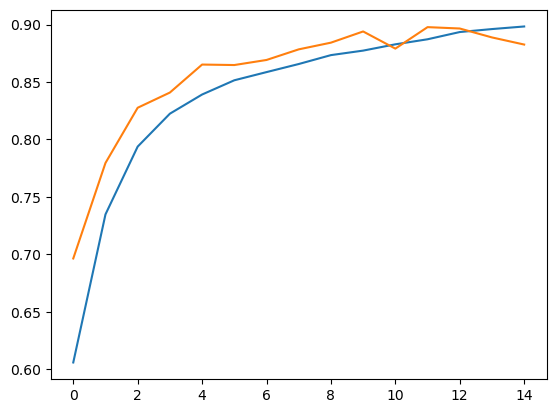

In [7]:
models = []
dropOut_boundary = [0.2, 0.5, 0.3]
# check the batch size and learning rate, and complete the model before training
escape_for_loop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)


model = CNN_dropOut(0.2, 6)
tracking = model.fit(
train32_generator,
steps_per_epoch=train32_generator.n // 32,
validation_data=valid32_generator,
validation_steps=valid32_generator.n // 32,
epochs=20,
verbose=1, callbacks=[escape_for_loop]
)

plt.plot(tracking.history['accuracy'])
plt.plot(tracking.history['val_accuracy'])
plt.title('Accuracy with ' + str(0.2) +' drop out ')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
            
        
        

In [ ]:
model = CNN_dropOut(0.4, 6)
tracking = model.fit(
train32_generator,
steps_per_epoch=train32_generator.n // 32,
validation_data=valid32_generator,
validation_steps=valid32_generator.n // 32,
epochs=20,
verbose=1, callbacks=[escape_for_loop]
)

plt.plot(tracking.history['accuracy'])
plt.plot(tracking.history['val_accuracy'])
plt.title('Accuracy with ' + str(0.4) +' drop out ')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
models.append(model)

Epoch 1/20
2040/2040 [==============================] - 4622s 2s/step - loss: 1.1481 - accuracy: 0.5576 - val_loss: 1.0232 - val_accuracy: 0.6402
Epoch 2/20
 155/2040 [=>............................] - ETA: 1:04:12 - loss: 0.9417 - accuracy: 0.6470

In [ ]:
model = CNN_dropOut(0.5, 6)
    tracking = model.fit(
    train32_generator,
    steps_per_epoch=train32_generator.n // 32,
    validation_data=valid32_generator,
    validation_steps=valid32_generator.n // 32,
    epochs=20,
    verbose=1, callbacks=[escape_for_loop]
    )

    plt.plot(tracking.history['accuracy'])
    plt.plot(tracking.history['val_accuracy'])
    plt.title('Accuracy with ' + str(dr) +' drop out ')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()
    models.append(model)